# K-NN Method for Stochastic Streamflow Simulation   

**Author: Andrew Nachtigal**

The variability of major river system streamflows is a key element in the study of risk and uncertainty for policy analysis and has implications for a range of planning areas, including power generation, managing valuable biological populations, agriculture irigation, and flood control policy. Stochastic streamflow simulation methods attempt to incorporate variability in modeling while realistically reproducting observed historical statistical streamflow characteristics.

This notebook describes a method for stochastic simulation of streamflow sequences. Historical streamflow data for the Colorado River is analyzed using the R program language.

In [152]:
library(readxl)
library(ggplot2)
library(plyr)
library(dplyr)
library(lubridate)
library(moments)
library(scales)
library(sm)
library(stats)
library(gridExtra)
library(FNN)

**Data Source**  
United States Geological Survey (USGS)  
Colorado River Streamflow for USGS Gauge 09072500 at Glenwood Springs, CO
  
Natural Streamflow for the period 1906 to 2015  
Colorado River at Glenwood Springs, CO, USGS Guage 09072500  
Data url: https://www.usbr.gov/lc/region/g4000/NaturalFlow/current.html  

In [29]:
# Annual Streamflow Data
library(readxl)
gsWY <- read_xlsx("~/Documents/PROJECTS/Hydro/Data/Colorado River/NaturalFlows1906-2015.xlsx", 
                  sheet = 'AnnualWYTotal Natural Flow',
                  range = "A5:B115", col_names = TRUE)

**Data Cleaning Steps** 

* Subset data range to water years 1906 - 1996.
* Convert data units from ac-ft/yr to m^3/s.
* Assign column names.

In [5]:
endWY <- which(gsWY$`Water Year`==1995)
gsWY95 <- gsWY[0:endWY,]
gsWY95$`(ac-ft/yr)` <- gsWY95$`(ac-ft/yr)`*0.00003919
names(gsWY95) <- c("WaterYear","Flow")

**Annual Streamflow Time Series Plot**

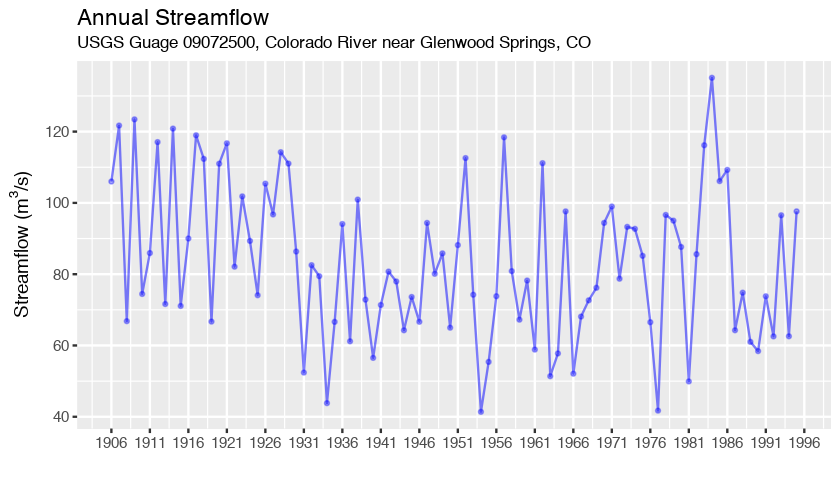

In [40]:
plotWY <- ggplot(gsWY95, aes(WaterYear, Flow)) + 
  geom_point(size=0.75,alpha=0.35,colour="blue") + 
  geom_line(alpha=0.5,colour="blue") +
  scale_x_continuous(name="", breaks=seq(1906,1996,5),limits=c(1906, 1995)) +
    xlab("") + ylab(expression(Streamflow~"("*m^{3}*"/s)")) +
    labs(title = "Annual Streamflow", subtitle = "USGS Guage 09072500, Colorado River near Glenwood Springs, CO")
options(repr.plot.width  = 7, repr.plot.height = 4)
plotWY

In [9]:
# Monthly Streamflow Data
library(readxl)
gsMNF <- read_xlsx("~/Documents/PROJECTS/Hydro/Data/Colorado River/NaturalFlows1906-2015.xlsx", 
                  sheet = 'Total Natural Flow',
                  range = "A5:B1328", col_names = TRUE,
                  col_types = c("date","numeric"))

**Data Cleaning Steps** 
* Assign column names  
* Convert POSIXct datetime to date class variable
* Convert acre-feet per month to cubic meters per second  
* Subset data range to water years 1906 - 1995  
* Add lag variable and month factors

In [86]:
names(gsMNF) <- c("Date","Flow")
gsMNF$Date <- as.Date(gsMNF$Date, format="%Y-%m-%d")
endMNF <- which(gsMNF$Date=="1995-09-30")
gsMNF95 <- gsMNF[0:endMNF,]
gsMNF95$Flow <- gsMNF95$Flow*0.00046936
gsMNF95$Lag1 <- lag(gsMNF95$Flow, k=1)
gsMNF95$Month <- as.factor(format(gsMNF95$Date,'%m'))
gsMNF95$MonthAbb <- mapvalues(gsMNF95$Month, c("01","02","03","04","05","06","07","08","09","10","11","12"), 
                              to = c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"))
# head(gsMNF95)

**Monthly Streamflow Time Series Plot**

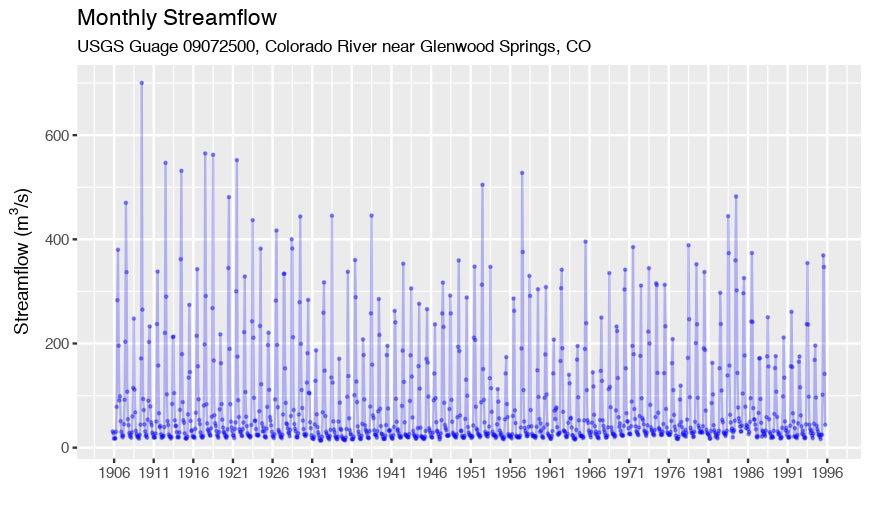

In [77]:
plotMNF <- ggplot(gsMNF95, aes(Date, Flow)) + 
  geom_point(size=0.25,alpha=0.35,colour="blue") + 
  geom_line(alpha=0.25,colour="blue") +
  theme(axis.text.x = element_text(angle = 0)) +
  (scale_x_date(breaks=date_breaks("5 year"), labels=date_format("%Y"), 
                limits = c(as.Date("1905-10-31"), as.Date("1995-09-30")))) +
  (scale_y_continuous(labels = scales::comma)) +
  xlab("") + ylab(expression(Streamflow~"("*m^{3}*"/s)")) +
  labs(title = "Monthly Streamflow", subtitle = "USGS Guage 09072500, Colorado River near Glenwood Springs, CO")
options(repr.plot.width  = 7.25, repr.plot.height = 4.25)
plotMNF

**Monthly Streamflow Analysis**

Calculate historical streamflow statistics: monthly mean flows, standard deviation, coefficient of skewness, maximum and minimum flows.

In [48]:
mnthMean <- ddply(gsMNF95, .(Month), summarize, mnthMean=mean(Flow))
mnthSD <- ddply(gsMNF95, .(Month), summarize, mnthSD=sd(Flow))
mnthSkew <- ddply(gsMNF95, .(Month), summarize, mnthSkew=skewness(Flow))
mnthMin <- ddply(gsMNF95, .(Month), summarize, mnthMin=min(Flow))
mnthMax <- ddply(gsMNF95, .(Month), summarize, mnthMax=max(Flow))

**Distribution of Monthly Streamflow**

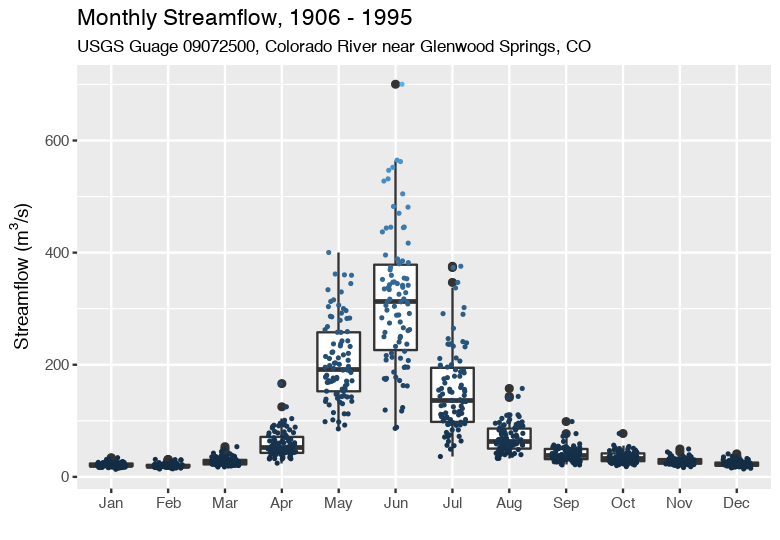

In [76]:
g <- ggplot(data = gsMNF95, mapping = aes(x = MonthAbb, y = Flow))
g + geom_boxplot(size=0.5) + 
  geom_jitter(aes(color = Flow), size=0.4, show.legend=FALSE, width=0.25) + 
  ylab(expression(Streamflow~"("*m^{3}*"/s)")) + xlab("") +
  labs(title = "Monthly Streamflow, 1906 - 1995", subtitle = "USGS Guage 09072500, Colorado River near Glenwood Springs, CO")
options(repr.plot.width  = 6.5, repr.plot.height = 4.5)

**Histogram of Monthly Streamflow**

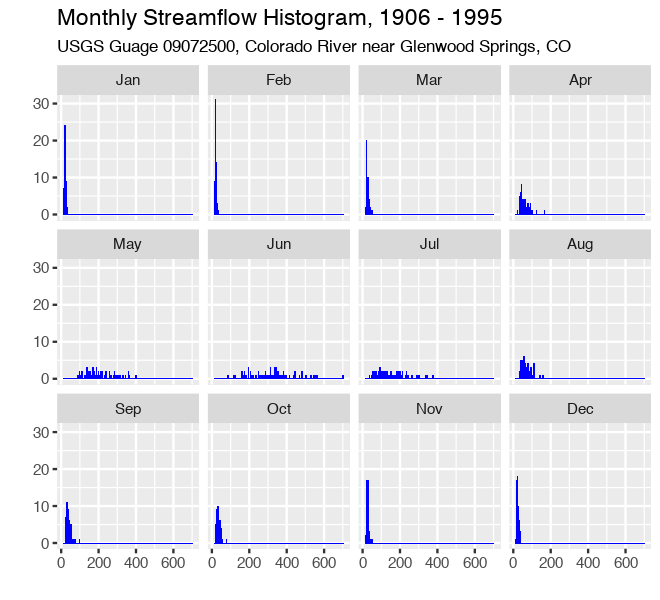

In [153]:
d <- ggplot(data = gsMNF95, aes(x = Flow)) + geom_histogram(binwidth = 2, fill = "blue")
d + facet_wrap(~ MonthAbb, ncol=4) +
 labs(title = "Monthly Streamflow Histogram, 1906 - 1995", 
      subtitle = "USGS Guage 09072500, Colorado River near Glenwood Springs, CO") + 
 ylab("") + xlab("")
 options(repr.plot.width  = 3.5, repr.plot.height = 3)

In [107]:
# split monthly data
splitMnth <- split(gsMNF95, gsMNF95$Month)

### Stochastic Streamflow Simulation Method using k-Nearest Neighbors with Local Polynomial Regression

A number of methods for modeling hydrologic time series have been developed. This analysis implements a nonparametric method of local regression combined with resampling residual errors to obtain stochastic sequences of streamflows not observed in the historical record. This method allows allow for better modeling of the variability of uncertain future streamflows. 

The k-NN algorithm can be described as follows:  
1. Fit a local polynomial for each month dependent on the previous month;
2. Save the residuals from the local regression fit;
3. Given the current month's streamflow, use the local regression fit to estimate the mean flow of the next month streamflow;
4. Obtain the k-nearest neigbors for the current month streamflow and assign weights to these k-neighbors based on their distances, with the nearest neighbor getting the largest weight and the farthest neighbor the least weight;
5. Normalize the weights to create a probability mass function (pmf);
6. Resample one of the neighbors using the weight pmf. The residual of the sampled neighbor is added to the mean estimate streamflow from step 3;
7. Repeat these steps for other months to simulate streamflow sequences for many years.  


### Local Nonparametric Regression Estimation - Month-to-Month Streamflow Dependency

Local regression is an approach for fitting flexible non-linear functions which involves computing the fit at a target point x0 using only the nearby training observations. To simualtion method, a local nonparametric regression is fitted to the successive monthly flows – e.g., a regression between March and February flows. Given the flow in the current month the fitted regression is used to obtain the mean flow of the next month. 

Several components of the local fit must be specified: the bandwidth, the degree of local polynomial, the weight function and the fitting criterion. Of these, bandwidth selection plays a key role, and is explored in greater detail here.

**Local Regression Components**

The bandwidth for local regression has a critical effect on the local regression fit. A small bandwidth will result in the smoothing window not capturing enough data, resulting in a noisy, large variance fit. If bandwidth is too large the local polynomial may not fit the data well within the smoothing window, and the fit will have large bias. Bandwidth must be chosen to compromise bias-variance trade-off.

A low degree local polynomial is fit to each data subset and the bandwidth is then chosen to obtain a good fit. Low degree polynomials are first or second degree - linear or locally quadratic. First degree polynomials are used in this analysis.

The weight function gives the most weight to the data points nearest the point of estimation and the least weight to the data points that are furthest away.  

**Bandwidth Selection**  

Local linear regression fits are estimated with different bandwidth alphas to explore fit. 

The R locfit package is used to estimate fit.

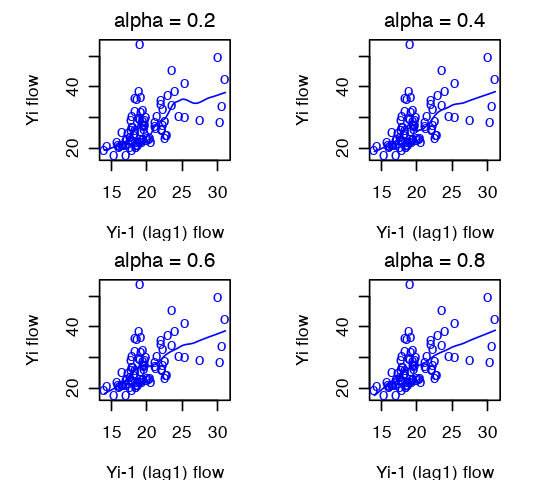

In [142]:
mnthData <- splitMnth$`03` # March data

library(locfit)
par(mfrow=c(2,2))
par(mar=c(4,5,2,2))
alp <- c(0.2,0.4,0.6,0.8)
for(a in alp) {
  fit <- locfit(Flow~Lag1, data=mnthData, alpha=a, deg=1)
  plot(fit, get.data=T, col="blue",
       main=paste("alpha =",a), 
       xlab="Yi-1 (lag1) flow", 
       ylab="Yi flow")
}
options(repr.plot.width  = 4.5, repr.plot.height = 4)

### Diagnostics and Goodness of Fit  

The nonparametric regression fit depends significantly on the choice of smoothing parameter. For local regression, residuals are defined as the difference between observed and fitted values and are an important diagnostic component in assessing fit.

Plotting the residuals in various ways is a good way to detect lack of fit, dependence of residual variance on predictor variables or mean response, detect departure from normality, and detect correlation between residuals.

**Residual Plots**

The following plots are smoothed Residual Plots, residuals vs. predictors.

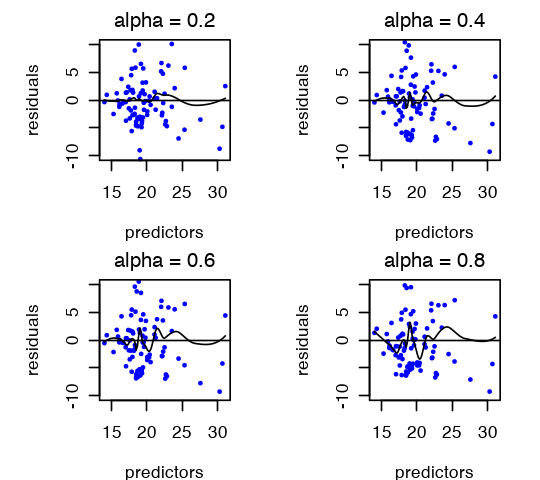

In [143]:
par(mfrow=c(2,2))
par(mar=c(4,5,2,2))
alp <- c(0.2,0.4,0.6,0.8)
for(a in alp) {
  fit <- locfit(Flow~Lag1, data=mnthData, alpha=a, deg=2)
  res <- residuals(fit)
  fit2 <- locfit.raw(mnthData$Lag1, res, alpha=0.3)
  plot(mnthData$Lag1, res, pch=16, col="blue", cex=.5,
       main=paste("alpha =",a), 
       ylim=c(-10,10), 
       xlab="predictors", 
       ylab="residuals")
  lines(fit2)
  abline(h=0,lty=1)
}
options(repr.plot.width  = 4.5, repr.plot.height = 4)

**Generalized Cross Validation**

Generalized cross validation as objective Criteria for optimal bandwidth.

The locfit alpha argument controls the bandwidth. When alpha is given as a single number, it represents a nearest neighbor fraction. The generalized cross validation (GCV) score for local estimate provides an approximation to cross validation and is a good estimate of the predictive error when the dataset is large. The GCV uses all points from a neighborhood and estimates yi with various neighborhood sizes and finds the neighborhood that gives the lowest score, which determines alpha.

The fitted degrees of freedom is a global criteria characterizing the overall amount of smoothing. The degrees of freedom of a local fit provide a generalization of the number of parameters of a parametric model.

Warning message in lfproc(x, y, weights = weights, cens = cens, base = base, geth = geth, :
“Estimated rdf < 1.0; not estimating variance”Warning message in lfproc(x, y, weights = weights, cens = cens, base = base, geth = geth, :
“Estimated rdf < 1.0; not estimating variance”Warning message in lfproc(x, y, weights = weights, cens = cens, base = base, geth = geth, :
“Estimated rdf < 1.0; not estimating variance”

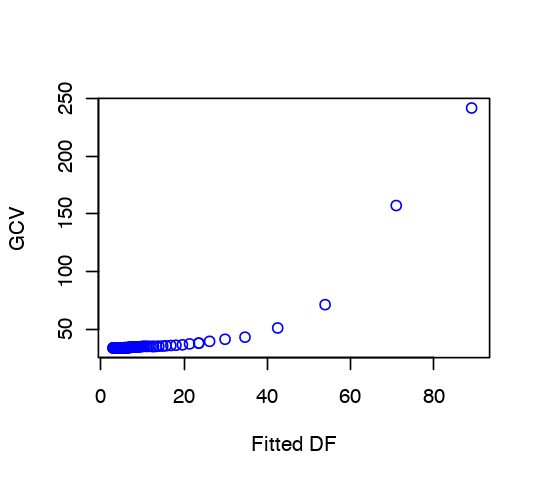

In [144]:
y <- mnthData$Flow
x <- mnthData$Lag1

gcvMnth <- gcvplot(y~x, kern="gauss", deg=1, ev=dat(), alpha=seq(0.01, 0.99, by=.01))
plot(gcvMnth,col="blue")
options(repr.plot.width  = 4.5, repr.plot.height = 4)

# Fit a locally linear polynomial model with bandwidths
# data.frame(bandwidth = gcvMnth$alpha, GCV = round(gcvMnth$values), DF=round(gcvMnth$df,1))
# alphaMnth = gcvMnth$alpha[which.min(gcvMnth$values)]

**References:**  

James, G., Witten, D., Hastie, T., Tibshirani, R., An Introduction to Statistical Learning, Springer, 2013.  
Loader, C., Local Regression and Likelihood, Springer, New York, 1999.  
Prairie, J., Rajagopalan, B., Zagona, E., Modified K-NN Model for Stochastic Streamflow Simulation, 2006  

### Local Regression: Fitting All Month-to-Month Dependencies

In [128]:
# JAN
mnthData <- splitMnth$`01`
y <- mnthData$Flow
x <- mnthData$Lag1
fitJAN <- locfit(y~x, data=mnthData, alpha=0.3, deg=1)
resJAN <- residuals(fitJAN)

# FEB
mnthData <- splitMnth$`02`
y <- mnthData$Flow
x <- mnthData$Lag1
fitFEB <- locfit(y~x, data=mnthData, alpha=0.3, deg=1)
resFEB <- residuals(fitFEB)

# MAR
mnthData <- splitMnth$`03`
y <- mnthData$Flow
x <- mnthData$Lag1
fitMAR <- locfit(y~x, data=mnthData, alpha=0.35, deg=1)
resMAR <- residuals(fitMAR)

# APR
mnthData <- splitMnth$`04`
y <- mnthData$Flow
x <- mnthData$Lag1
fitAPR <- locfit(y~x, data=mnthData, alpha=0.3, deg=1)
resAPR <- residuals(fitAPR)

# MAY
mnthData <- splitMnth$`05`
y <- mnthData$Flow
x <- mnthData$Lag1
fitMAY <- locfit(y~x, data=mnthData, alpha=0.3, deg=1)
resMAY <- residuals(fitMAY)

# JUN
mnthData <- splitMnth$`06`
y <- mnthData$Flow
x <- mnthData$Lag1
fitJUN <- locfit(y~x, data=mnthData, alpha=0.35, deg=1)
resJUN <- residuals(fitJUN)

# JUL
mnthData <- splitMnth$`07`
y <- mnthData$Flow
x <- mnthData$Lag1
fitJUL <- locfit(y~x, data=mnthData, alpha=0.27, deg=1)
resJUL <- residuals(fitJUL)

# AUG
mnthData <- splitMnth$`08`
y <- mnthData$Flow
x <- mnthData$Lag1
fitAUG <- locfit(y~x, data=mnthData, alpha=0.4, deg=1)
resAUG <- residuals(fitAUG)

# SEP
mnthData <- splitMnth$`09`
y <- mnthData$Flow
x <- mnthData$Lag1
fitSEP <- locfit(y~x, data=mnthData, alpha=0.28, deg=1)
resSEP <- residuals(fitSEP)

# OCT
mnthData <- splitMnth$`10`
y <- mnthData$Flow[-1] # adjust for water year data
x <- mnthData$Lag1[-1] # adjust for water year data### Local Regression - Fit All Months
fitOCT <- locfit(y~x, data=mnthData, alpha=0.3, deg=1)
resOCT <- residuals(fitOCT)

# NOV
mnthData <- splitMnth$`11`
y <- mnthData$Flow
x <- mnthData$Lag1
fitNOV <- locfit(y~x, data=mnthData, alpha=0.44, deg=1)
resNOV <- residuals(fitNOV)

# DEC
mnthData <- splitMnth$`12`
y <- mnthData$Flow
x <- mnthData$Lag1
fitDEC <- locfit(y~x, data=mnthData, alpha=0.3, deg=1)
resDEC <- residuals(fitDEC)

### K-NN Method for Streamflow Simulation

In [117]:
simulateWY <- function(initSep) {
  sim90WY <- list()
  simEstMuOct <- list()
  for (i in 1:90){

    # OCT ##############################################################

    estMuOCT <- predict(fitOCT, initSep) 
    estMuOCT
    
    # get Lag1 k-nearest-neighbors
    mnthData <- splitMnth$`10` 
    y <- mnthData$Flow[-1] # [-1,] trim for OCT
    x <- mnthData$Lag1[-1] # [-1,] trim for OCT
    muMnthLag <- initSep
    knnMnthLag <- get.knnx(data=x, query=muMnthLag, k=10, algorithm=c("kd_tree", "cover_tree", "CR", "brute"))

    # get Lag1 k-nearest-neighbor residuals
    knnResMnth <- resOCT[knnMnthLag$nn.index]

    # normalized nearest-neighbor distance weight vector
    sumDist <- sum(knnMnthLag$nn.dist)
    wtvec <- knnMnthLag$nn.dist/sumDist

    # simulated next time step value: y*t = yˆ*t + e*t (estimated mean yˆ*t + sampled residual e*t)
    simOCT <- estMuOCT + sample(knnResMnth,1,prob=wtvec)
    
    # NOV ##############################################################

    estMuNOV <- predict(fitNOV, simOCT)
    
    # get Lag1 k-nearest-neighbors
    mnthData <- splitMnth$`11` 
    y <- mnthData$Flow
    x <- mnthData$Lag1 
    muMnthLag <- simOCT 
    knnMnthLag <- get.knnx(data=x, query=muMnthLag, k=10, algorithm=c("kd_tree", "cover_tree", "CR", "brute"))
    
    # get Lag1 k-nearest-neighbor residuals
    knnResMnth <- resNOV[knnMnthLag$nn.index]  
    
    # normalized nearest-neighbor distance weight vector
    sumDist <- sum(knnMnthLag$nn.dist)
    wtvec <- knnMnthLag$nn.dist/sumDist

    # simulated next time step value
    simNOV <- estMuNOV + sample(knnResMnth,1,prob=wtvec)
    
    # DEC ##############################################################

    estMuDEC <- predict(fitDEC, simNOV) 
    
    # get Lag1 k-nearest-neighbors
    mnthData <- splitMnth$`12` 
    y <- mnthData$Flow # for graph
    x <- mnthData$Lag1 
    muMnthLag <- simNOV 
    knnMnthLag <- get.knnx(data=x, query=muMnthLag, k=10, algorithm=c("kd_tree", "cover_tree", "CR", "brute"))
    
    # get Lag1 k-nearest-neighbor residuals
    knnResMnth <- resDEC[knnMnthLag$nn.index] 
    
    # normalized nearest-neighbor distance weight vector
    sumDist <- sum(knnMnthLag$nn.dist)
    wtvec <- knnMnthLag$nn.dist/sumDist
    
    # simulated next time step value
    simDEC <- estMuDEC + sample(knnResMnth,1,prob=wtvec)  
    
    # JAN ##############################################################

    estMuJAN <- predict(fitJAN, simDEC)  

    # get Lag1 k-nearest-neighbors 
    mnthData <- splitMnth$`01`  
    y <- mnthData$Flow # for graph
    x <- mnthData$Lag1 
    muMnthLag <- simDEC  
    knnMnthLag <- get.knnx(data=x, query=muMnthLag, k=10, algorithm=c("kd_tree", "cover_tree", "CR", "brute"))
    
    # get Lag1 k-nearest-neighbor residuals
    knnResMnth <- resJAN[knnMnthLag$nn.index] 
    
    # normalized nearest-neighbor distance weight vector
    sumDist <- sum(knnMnthLag$nn.dist)
    wtvec <- knnMnthLag$nn.dist/sumDist
    
    # simulated next time step value
    simJAN <- estMuJAN + sample(knnResMnth,1,prob=wtvec)  
    
    # FEB ##############################################################

    estMuFEB <- predict(fitFEB, simJAN) 
    
    # get Lag1 k-nearest-neighbors 
    mnthData <- splitMnth$`02`  
    y <- mnthData$Flow # for graph
    x <- mnthData$Lag1 
    muMnthLag <- simJAN 
    knnMnthLag <- get.knnx(data=x, query=muMnthLag, k=10, algorithm=c("kd_tree", "cover_tree", "CR", "brute"))
    
    # get Lag1 k-nearest-neighbor residuals
    knnResMnth <- resFEB[knnMnthLag$nn.index] 
    
    # normalized nearest-neighbor distance weight vector
    sumDist <- sum(knnMnthLag$nn.dist)
    wtvec <- knnMnthLag$nn.dist/sumDist
    
    # simulated next time step value
    simFEB <- estMuFEB + sample(knnResMnth,1,prob=wtvec) 
    
    # MAR ##############################################################

    estMuMAR <- predict(fitMAR, simFEB) 
    
    # get Lag1 k-nearest-neighbors 
    mnthData <- splitMnth$`03`  
    y <- mnthData$Flow # for graph
    x <- mnthData$Lag1 
    muMnthLag <- simFEB  
    knnMnthLag <- get.knnx(data=x, query=muMnthLag, k=10, algorithm=c("kd_tree", "cover_tree", "CR", "brute"))
    
    # get Lag1 k-nearest-neighbor residuals
    knnResMnth <- resMAR[knnMnthLag$nn.index] 
    
    # normalized nearest-neighbor distance weight vector
    sumDist <- sum(knnMnthLag$nn.dist)
    wtvec <- knnMnthLag$nn.dist/sumDist
    
    # simulated next time step value
    simMAR <- estMuMAR + sample(knnResMnth,1,prob=wtvec) 

    # APR ##############################################################

    estMuAPR <- predict(fitAPR, simMAR)  
    
    # get Lag1 k-nearest-neighbors 
    mnthData <- splitMnth$`04`  
    y <- mnthData$Flow # for graph
    x <- mnthData$Lag1 
    muMnthLag <- simMAR  
    knnMnthLag <- get.knnx(data=x, query=muMnthLag, k=10, algorithm=c("kd_tree", "cover_tree", "CR", "brute"))
    
    # get Lag1 k-nearest-neighbor residuals
    knnResMnth <- resAPR[knnMnthLag$nn.index] 
    
    # normalized nearest-neighbor distance weight vector
    sumDist <- sum(knnMnthLag$nn.dist)
    wtvec <- knnMnthLag$nn.dist/sumDist
    
    # simulated next time step value
    simAPR <- estMuAPR + sample(knnResMnth,1,prob=wtvec)  
    
    # MAY ##############################################################

    estMuMAY <- predict(fitMAY, simAPR)  

    # get Lag1 k-nearest-neighbors 
    mnthData <- splitMnth$`05`  
    y <- mnthData$Flow # for graph
    x <- mnthData$Lag1 
    muMnthLag <- simAPR  
    knnMnthLag <- get.knnx(data=x, query=muMnthLag, k=10, algorithm=c("kd_tree", "cover_tree", "CR", "brute"))
    
    # get Lag1 k-nearest-neighbor residuals
    knnResMnth <- resMAY[knnMnthLag$nn.index] 
    
    # normalized nearest-neighbor distance weight vector
    sumDist <- sum(knnMnthLag$nn.dist)
    wtvec <- knnMnthLag$nn.dist/sumDist
    
    # simulated next time step value
    simMAY <- estMuMAY + sample(knnResMnth,1,prob=wtvec)
    
    # JUN ##############################################################

    estMuJUN <- predict(fitJUN, simMAY) 
    
    # get Lag1 k-nearest-neighbors 
    mnthData <- splitMnth$`06`  
    y <- mnthData$Flow # for graph
    x <- mnthData$Lag1 
    muMnthLag <- simMAY  
    knnMnthLag <- get.knnx(data=x, query=muMnthLag, k=10, algorithm=c("kd_tree", "cover_tree", "CR", "brute"))

    # get Lag1 k-nearest-neighbor residuals
    knnResMnth <- resJUN[knnMnthLag$nn.index]
    
    # normalized nearest-neighbor distance weight vector
    sumDist <- sum(knnMnthLag$nn.dist)
    wtvec <- knnMnthLag$nn.dist/sumDist
    
    # simulated next time step value
    simJUN <- estMuJUN + sample(knnResMnth,1,prob=wtvec) 
    
    # JUL ##############################################################

    estMuJUL <- predict(fitJUL, simJUN)  
    
    # get Lag1 k-nearest-neighbors 
    mnthData <- splitMnth$`07`  
    y <- mnthData$Flow # for graph
    x <- mnthData$Lag1 
    muMnthLag <- simJUN 
    knnMnthLag <- get.knnx(data=x, query=muMnthLag, k=10, algorithm=c("kd_tree", "cover_tree", "CR", "brute"))
    
    # get Lag1 k-nearest-neighbor residuals
    knnResMnth <- resJUL[knnMnthLag$nn.index] 
    # knnResMnth
    
    # normalized nearest-neighbor distance weight vector
    sumDist <- sum(knnMnthLag$nn.dist)
    wtvec <- knnMnthLag$nn.dist/sumDist
    
    # simulated next time step value
    simJUL <- estMuJUL + sample(knnResMnth,1,prob=wtvec) 
    
    # AUG ##############################################################

    estMuAUG <- predict(fitAUG, simJUL)  

    # get Lag1 k-nearest-neighbors 
    mnthData <- splitMnth$`08`
    y <- mnthData$Flow # for graph
    x <- mnthData$Lag1 
    muMnthLag <- simJUL
    knnMnthLag <- get.knnx(data=x, query=muMnthLag, k=10, algorithm=c("kd_tree", "cover_tree", "CR", "brute"))
    
    # get Lag1 k-nearest-neighbor residuals
    knnResMnth <- resAUG[knnMnthLag$nn.index]
    # knnResMnth
    
    # normalized nearest-neighbor distance weight vector
    sumDist <- sum(knnMnthLag$nn.dist)
    wtvec <- knnMnthLag$nn.dist/sumDist
    
    # simulated next time step value
    simAUG <- estMuAUG + sample(knnResMnth,1,prob=wtvec) 
    
    # SEP ##############################################################

    estMuSEP <- predict(fitSEP, simAUG) 
    
    # get Lag1 k-nearest-neighbors 
    mnthData <- splitMnth$`09`
    y <- mnthData$Flow # for graph
    x <- mnthData$Lag1 
    muMnthLag <- simAUG
    knnMnthLag <- get.knnx(data=x, query=muMnthLag, k=10, algorithm=c("kd_tree", "cover_tree", "CR", "brute"))

    # get Lag1 k-nearest-neighbor residuals
    knnResMnth <- resSEP[knnMnthLag$nn.index]
    
    # normalized nearest-neighbor distance weight vector
    sumDist <- sum(knnMnthLag$nn.dist)
    wtvec <- knnMnthLag$nn.dist/sumDist
    
    # simulated next time step value
    simSEP <- estMuSEP + sample(knnResMnth,1,prob=wtvec) 
    
    simWY <- c(simOCT,simNOV,simDEC,simJAN,simFEB,simMAR,simAPR,simMAY,simJUN,simJUL,simAUG,simSEP)

    sim90WY[[i]] <- simWY
    initSep <- simWY[12]
  }
  return(sim90WY)
}

### K-NN Local Regression with Residual Resampling

**Scatterplot of Local Regression k-NN Bootstrap Simulation**

* current month Yi flow - month Yi-1 flow
* local regression fit
* k neighbors of lag1 flow

In [145]:
# set month MARCH
mnthData <- splitMnth$`03`

In [146]:
xMnthLag <- mnthMean$mnthMean[2]
knnMnthLag <- get.knnx(data=mnthData$Lag1, query=xMnthLag, k=10, algorithm=c("kd_tree", "cover_tree", "CR", "brute"))
knnMnthLagPts <- mnthData$Lag1[knnMnthLag$nn.index]
knnMnthPts <- mnthData$Flow[knnMnthLag$nn.index]

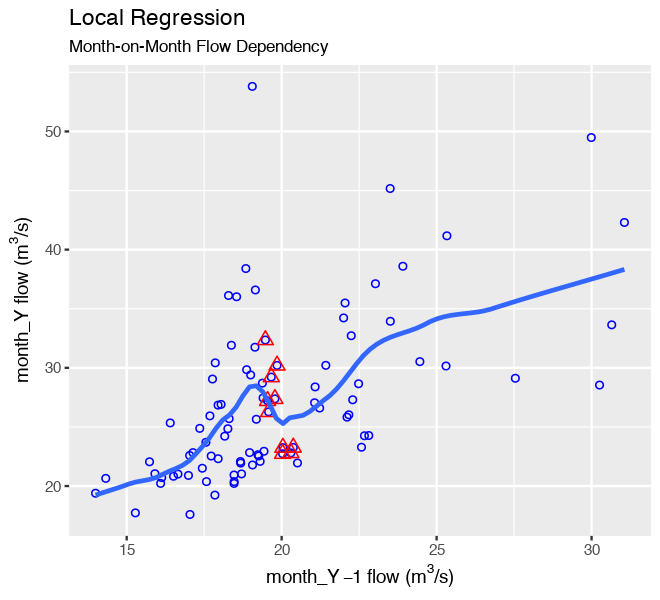

In [151]:
plotLocfit <- ggplot(data=mnthData, aes(x=Lag1, y=Flow)) +
  geom_point(colour="blue",shape=1) +
  geom_point(data=mnthData[knnMnthLag$nn.index,], aes(x=Lag1, y=Flow), colour="red", size=3, shape=2) +
  geom_smooth(method=locfit, formula = y ~ lp(x, nn=.35, deg=1),se = F)  +
  xlab(expression(month_Y-1~flow~"("*m^{3}*"/s)")) + 
  ylab(expression(month_Y~flow~"("*m^{3}*"/s)")) + 
  labs(title = "Local Regression", subtitle = "Month-on-Month Flow Dependency")
plotLocfit
options(repr.plot.width  = 5.5, repr.plot.height = 5)

### Historical streamflow statistics - for model comparison:

In [123]:
# Calculate statistics
mnthMean <- ddply(gsMNF95, .(Month), summarize, mnthMean=mean(Flow))
mnthSD <- ddply(gsMNF95, .(Month), summarize, mnthSD=sd(Flow))
mnthSkew <- ddply(gsMNF95, .(Month), summarize, mnthSkew=skewness(Flow))
mnthMin <- ddply(gsMNF95, .(Month), summarize, mnthMin=min(Flow))
mnthMax <- ddply(gsMNF95, .(Month), summarize, mnthMax=max(Flow))

# Make Statistics Table
mnthStats <- as.data.frame(matrix(nrow=12,ncol=1))
mnthStats$Mean <- round(mnthMean$mnthMean,2)
mnthStats$SD <- round(mnthSD$mnthSD,2)
mnthStats$Skew <- round(mnthSkew$mnthSkew,2)
mnthStats$Min <- round(mnthMin$mnthMin,2)
mnthStats$Max <- round(mnthMax$mnthMax,2)

mnthStats$V1 <- c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec")
wy <- c("Oct","Nov","Dec","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep")

mnthStats <- mnthStats[match(wy, mnthStats$V1),]
mnthStats

,V1,Mean,SD,Skew,Min,Max
10,Oct,35.00,9.98,1.08,18.28,77.33
11,Nov,28.01,5.72,0.94,16.58,49.71
12,Dec,23.42,4.75,1.06,14.13,40.99
1,Jan,21.55,3.68,0.69,13.54,34.14
2,Feb,19.92,3.38,1.42,14.00,31.06
3,Mar,27.21,6.92,1.42,17.59,53.81
4,Apr,59.07,23.32,1.55,24.46,166.36
5,May,206.84,71.86,0.59,85.60,400.22
6,Jun,316.02,119.69,0.53,86.44,700.37
7,Jul,153.98,74.61,1.01,36.30,375.68


### Simulation Results  

* Simulate 90-year time series of streamflow sequences
* Simulate 250 streamflow sequences
* Plot distribution of simulated statistics vs. historical statistics

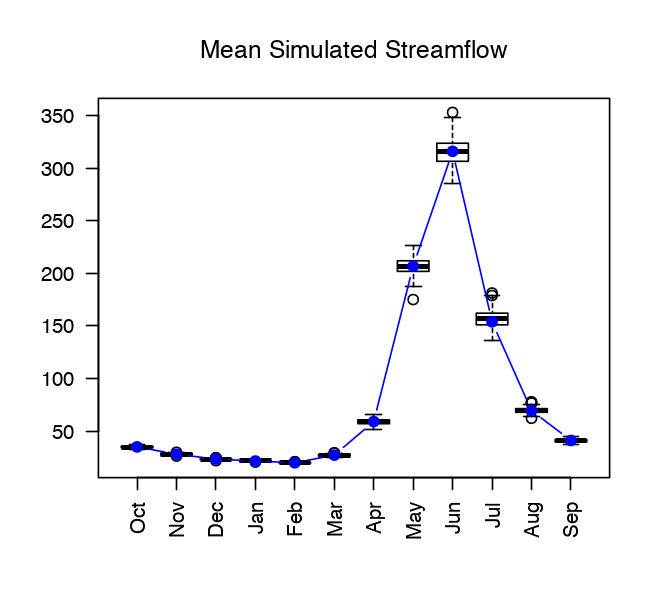

In [133]:
# set mean September streamflow as initial value
avgSEP <- mnthMean$mnthMean[10]

set.seed(1234)

sim.Mean <- list()
sim.Min <- list()
sim.Max <- list()
sim.SD <- list()
sim.Skew <- list()

for (i in 1:250){
sim90 <- simulateWY(avgSEP)
simFlow <-  as.data.frame(matrix(unlist(sim90), nrow=length(unlist(sim90[1]))))
rownames(simFlow) <- c("Oct","Nov","Dec","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep")

simMean <- round(apply(simFlow, 1, mean),2)
sim.Mean[[i]] <- simMean

simMin <- round(apply(simFlow, 1, min),2)
sim.Min[[i]] <- simMin

simMax <- round(apply(simFlow, 1, max),2)
sim.Max[[i]] <- simMax

simSD <- round(apply(simFlow, 1, sd),2)
sim.SD[[i]] <- simSD

simSkew <- round(apply(simFlow, 1, skewness),2)
sim.Skew[[i]] <- simSkew
}

sim.Mean <- ldply(sim.Mean, rbind)
sim.Min <- ldply(sim.Min, rbind)
sim.Max <- ldply(sim.Max, rbind)
sim.SD <- ldply(sim.SD, rbind)
sim.Skew <- ldply(sim.Skew, rbind)

# distribution of simulated mean flow vs. historical  
b.mean <- boxplot(sim.Mean, las=2)
points(mnthStats$Mean, type="b", col="blue", pch=19)
title(main="Mean Simulated Streamflow",cex=1.5)


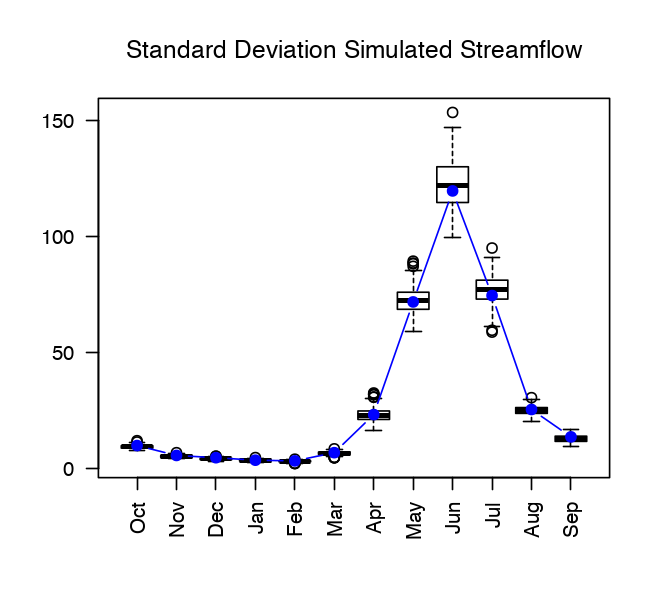

In [134]:
# distribution of simulated standard deviation vs. historical  
b.SD <- boxplot(sim.SD, las=2)
points(mnthStats$SD, type="b", col="blue", pch=19)
title(main="Standard Deviation Simulated Streamflow",cex=1.5)

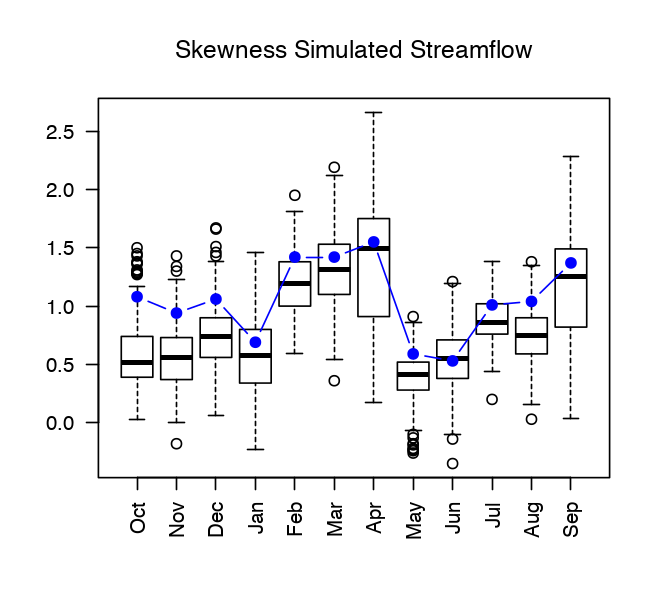

In [135]:
# distribution of simulated skew vs. historical  
b.Skew <- boxplot(sim.Skew, las=2)
points(mnthStats$Skew, type="b", col="blue", pch=19)
title(main="Skewness Simulated Streamflow",cex=1.5)

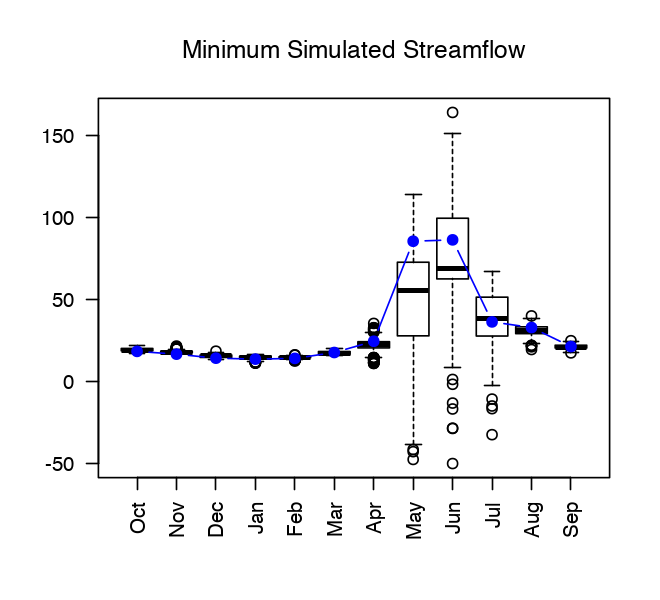

In [136]:
# distribution of simulated minimum flow vs. historical  
b.Min <- boxplot(sim.Min, las=2)
points(mnthStats$Min, type="b", col="blue", pch=19)
title(main="Minimum Simulated Streamflow",cex=1.5)

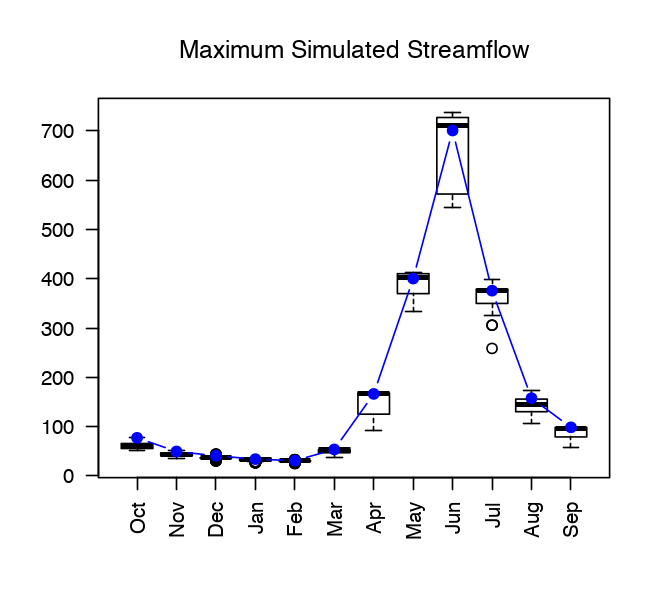

In [137]:
# distribution of simulated max flow vs. historical  
b.Max <- boxplot(sim.Max, las=2)
points(mnthStats$Max, type="b", col="blue", pch=19)
title(main="Maximum Simulated Streamflow",cex=1.5)

### Summary of Results  

The statistics from simulation ensembles and the historic data are shown as boxplots. Historic data is shown as a solid circle with a solid line connecting each month. The K-NN model preserved mean and standard deviation well. Skewness is fairly well preserved. Maximum flows are well preserved. However, the model generated some negative flows, during the Spring run-off months when variability is highest. This is regarded as an infeasible outcome. 

Overall the K-NN performed quite well with regard to historically observed streamflow statistical measures. 